ADVANCED LANE LINE DETECTION


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import glob
import sys
import os
import math
import pickle
import PIL
from PIL import Image

In [8]:
video_file_path = './project_video.mp4'

capture = cv2.VideoCapture(video_file_path)
ret, frame = capture.read()
cv2.imshow('frame',frame)
cv2.waitKey(0)
cv2.destroyWindow('frame')
    
# save frames
destination_path = './test_images/'

def capture_frames(video_path, destination_path):
    '''
    Utility function that captures and stores video frames

    '''
    cap = cv2.VideoCapture(video_file_path)

    print('Starting frame capture...')
    
    count = 0
    success = True
    while success:
        success, frame = cap.read()
        cv2.imwrite(destination_path + 'frame{:02}.jpg'.format(count), frame)
        count += 1

    print('Completed!')
  
if os.path.exists('frame_images'):
    pass
else:
    capture_frames(video_file_path, destination_path)

HELPER FUNCTIONS



In [9]:
def plot_images(data, layout='row', cols=2, figsize=(20, 12)):
    '''
    Utility function for plotting images
    :param data [(ndarray, string)]: List of data to display, [(image, title)]
    :param layout (string): Layout, row-wise or column-wise
    :param cols (number): Number of columns per row
    :param figsize (number, number): Tuple indicating figure size
    '''
    rows = math.ceil(len(data) / cols)
    f, ax = plt.subplots(figsize=figsize)
    if layout == 'row':
        for idx, d in enumerate(data):
            img, title = d

            plt.subplot(rows, cols, idx+1)
            plt.title(title, fontsize=20)
            plt.axis('off')
            if len(img.shape) == 2:
                plt.imshow(img, cmap='gray')
                
            elif len(img.shape) == 3:
                plt.imshow(img)
                
    elif layout == 'col':
        counter = 0
        for r in range(rows):
            for c in range(cols):
                img, title = data[r + rows*c]
                nb_channels = len(img.shape)
                
                plt.subplot(rows, cols, counter+1)
                plt.title(title, fontsize=20)
                plt.axis('off')
                if len(img.shape) == 2:
                    plt.imshow(img, cmap='gray')
                
                elif len(img.shape) == 3:
                    plt.imshow(img)
              
                counter += 1

    return ax

CAMERA CALIBRATION

Loaded camera calibration matrix & distortion coefficients!
starting camera calibration
calibration performed


<AxesSubplot:>

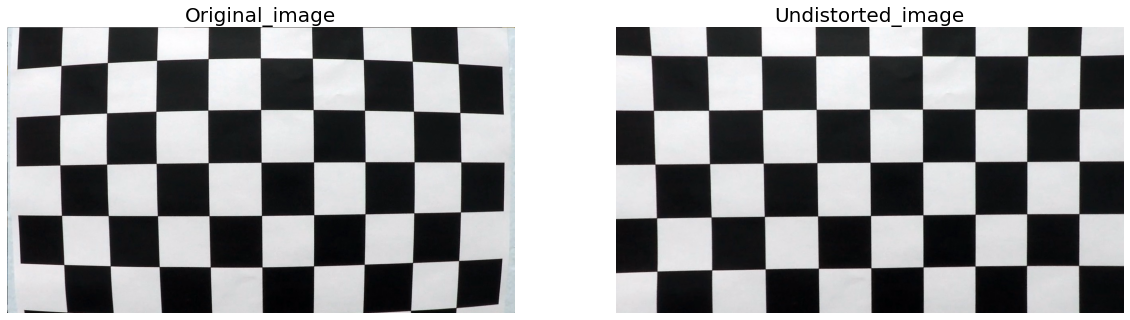

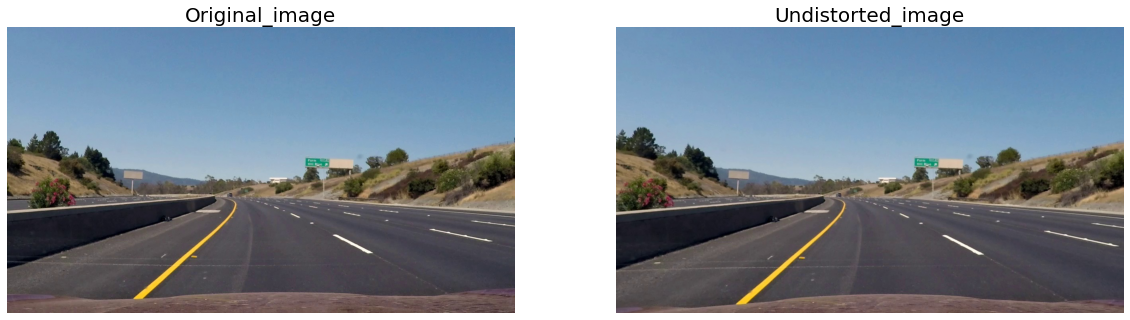

In [25]:
def camera_calibration():
    """
    wrapper function to find the camera calibration coordinates through chess board corners detection
    ideally should be perforemd on the images taken from camera that is going to be used in lane detection 
    
    """
    print('starting camera calibration')
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    obj_pt = np.zeros((6 * 9, 3), np.float32)
    obj_pt[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)
    
    chess_images = glob.glob('./camera_cal/*')
    nx = 9    # number of corners in x axis
    ny = 6    # number of corners in y axis
    
    obj_points = []    # 3d points in real world space
    img_points = []    # 2d points in image plane

    for image in chess_images:
        img = cv2.imread(image)
        gray_image  = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        det , corners = cv2.findChessboardCorners(gray_image, (nx, ny), None) 
        
        if det :
            img = cv2.drawChessboardCorners(img, (nx, ny), corners, det)
            #cv2.imshow('img',img)
            #cv2.waitKey(0)
            obj_points.append(obj_pt)
            img_points.append(corners)
            
    shape = (img.shape[1], img.shape[0])
    ret, mtx, dist, _ , _ = cv2.calibrateCamera(obj_points, img_points, shape, None, None)
    print('calibration performed')
    #cv2.distroyAllWindows()
    return mtx, dist
    
# calibration needed only once in the beginning and can be loaded in the next run form the saved file
if os.path.exists('camera_calib.p'):
    with open('camera_calib.p', mode='rb') as f:
        data = pickle.load(f)
        mtx, dist = data['mtx'], data['dist']
        print('Loaded camera calibration matrix & distortion coefficients!')
else:
    mtx, dist = camera_calibration()
    with open('camera_calib.p', mode='wb') as f:
        pickle.dump({'mtx': mtx, 'dist': dist}, f)
    
    
def undistort(distorted_image, mtx, dist):
    return cv2.undistort(distorted_image, mtx, dist, None, mtx)

mtx , dist = camera_calibration()
chess_img_path = './camera_cal/calibration1.jpg'
original_img = cv2.imread(chess_img_path)
undistorted_img = undistort(original_img, mtx, dist)
plot_images([
    (original_img, 'Original_image'),
    (undistorted_img, 'Undistorted_image')
])

img_path = './frame_images/frame00.jpg'
original_img = mpimg.imread(img_path)
undistorted_img = undistort(original_img, mtx, dist)
plot_images([
    (original_img, 'Original_image'),
    (undistorted_img, 'Undistorted_image')
])


CANNY EDGE DETECION AND HOUGH TRANSFORATION

In [11]:
rho = 3 # distance resolution in pixels of the Hough grid
theta = 0.5 * np.pi/180 # angular resolution in radians of the Hough grid
threshold = 100     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 50 #minimum number of pixels making up a line
max_line_gap =  40  # maximum gap in pixels between connectable line segments

def canny_conversion(img):
    """
    The function takes in image as an input and detect the edges due 
    to change in gradient
    """
    
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # converting to gray scale image for processing in opencv
    kernel_size = 5
    blurred_img = cv2.GaussianBlur(gray_img, (kernel_size,kernel_size), 0)  # blurring the image if the image is sharp
    canny = cv2.Canny(blurred_img, 50, 150)     # applying canny algorithm for edge detection
    return canny

def hough_transform(image, rho, theta, threshold, min_line_length, max_line_gap):
    """
    The function detects the lines through hough transform for a given 
    image and returns potential lines for the lanes
    
    """
    hough_lines = cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), minLineLength = min_line_length, maxLineGap = max_line_gap)
    return hough_lines 


In [12]:
# choosing the region of interest (triangular) where the lanes can be founded and ignoring other regions

def region_of_interest(img, vertices, vertices_inner):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    It also takes out the inner region defined by 'vertices_inner'
    """
    #defining blank masks to start with
    mask = np.zeros_like(img)
    mask_inner = np.zeros_like(img)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    #filling pixels inside the polygon defined by "vertices_inner" with the fill color
    cv2.fillPoly(mask_inner, vertices_inner, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    #returning image after removing the region defined by vertices_inner
    masked_image2 = cv2.bitwise_and((masked_image), (255-mask_inner))
    return masked_image2

gray = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2GRAY)
imshape = gray.shape
vertices = np.array([[(0.45*imshape[1],0.62*imshape[0]),(0.02*imshape[1], imshape[0]), (0.98*imshape[1], imshape[0]), (0.55*imshape[1],0.62*imshape[0])]], dtype=np.int32)
vertices_inner = np.array([[(0.5*imshape[1],0.62*imshape[0]),(0.3*imshape[1], imshape[0]), (0.7*imshape[1], imshape[0]), (0.5*imshape[1],0.62*imshape[0])]], dtype=np.int32)    


In [13]:
# function that returns image with lines detection 

def display_lines(image, lines, color=[255, 0, 0], thickness=5):
    """
    Helper function to draw the lines onto the image itself for visualization 
    taking the averaged lines on left and right side. 
    """
    left_line = lines[0]
    right_line = lines[1]
    cv2.line(image, (left_line[0], left_line[1]), (left_line[2], left_line[3]), color, thickness)  #draw both lines
    cv2.line(image, (right_line[0], right_line[1]), (right_line[2]+5, right_line[3]), color, thickness)

    return image    


In [14]:
def evaluate_line(m,b,y1,y0):
    """
    This function takes the parameters: slope 'm', 'b' and the
    y coordinate of the highest and lowest point of the lines
    'y0' and 'y1' to return the points x0, y0, x1 and y1 of the line
    
    """
    if (m==0):
        x0 = 0
        y0 = 0
        x1= 0
        y1 =0
    else:
        x0 = (y0-b)/m
        x1 = (y1-b)/m
    try:
        points = np.array([int(x1), int(y1), int(x0), int(y0)])
    except:
        points = np.array([0, 0, 0, 0])
    return points

In [15]:
# finding the average of lines detected by hough transforms and outputs the single line. 

def avg_slope_intercept(image, lines, y0, y1):
    """
    This function receives several potential lines detected form the 
    hough transformation and classifies them bethwen right and 
    left lane depending upon their slope
    """
    line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype = np.uint8)
    line_left_params = np.zeros(3)    # vector used to accumulate m, b and number of lines on each side
    line_right_params = np.zeros(3)
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y2-y1)/(x2-x1)  
            if(m>0.50 or m < -0.50):    # ignore lines with slopes not likely to correspond to lanes
                if(m<0):
                    line_left_params[0] = line_left_params[0] + m           # accumulate slope
                    line_left_params[1] = line_left_params[1] + y1-m*x1     # accumulate b
                    line_left_params[2] = line_left_params[2] + 1           # count number of lines
                else:
                    line_right_params[0] = line_right_params[0] + m
                    line_right_params[1] = line_right_params[1] + y1-m*x1
                    line_right_params[2] = line_right_params[2] + 1
    if(line_left_params[2] != 0):  
        line_left_params = line_left_params/line_left_params[2]          # if lines were encountered, average m and b
    if(line_right_params[2] != 0):
        line_right_params = line_right_params/line_right_params[2]
                
    line_left = evaluate_line(line_left_params[0], line_left_params[1], y0, y1)   # get x1,y1,x2 and y2 from m and b
    line_right = evaluate_line(line_right_params[0], line_right_params[1], y0, y1)
    
    return line_left, line_right

INITIAL IMPLEMENTATION TESTING PIPELINE WIHOUT BINARY IMAGE PROCESSING 

In [16]:
cap = cv2.VideoCapture(video_file_path)
while(cap.isOpened()):
  _, frame = cap.read()
  edges = canny_conversion(frame)
  masked_edges_image = region_of_interest((edges), vertices, vertices_inner)
  hough_lines = hough_transform(masked_edges_image, rho, theta, threshold, min_line_length, max_line_gap)
  averaged_lines = avg_slope_intercept(frame, hough_lines, int(0.632*imshape[0]), int(0.99*imshape[0]))
  line_image = display_lines(frame, averaged_lines)
  final_image = cv2.addWeighted(frame,0.8, line_image, 1, 1)
  cv2.imshow('video_output',final_image)
  if cv2.waitKey(1) == ord('q'):
    break
cap.release()
cv2.destroyAllWindows()

PERSPECTIVE TRANSFORMATION

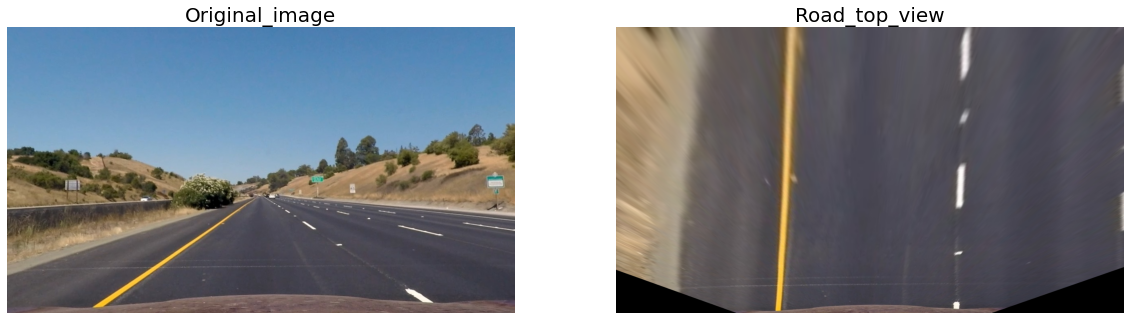

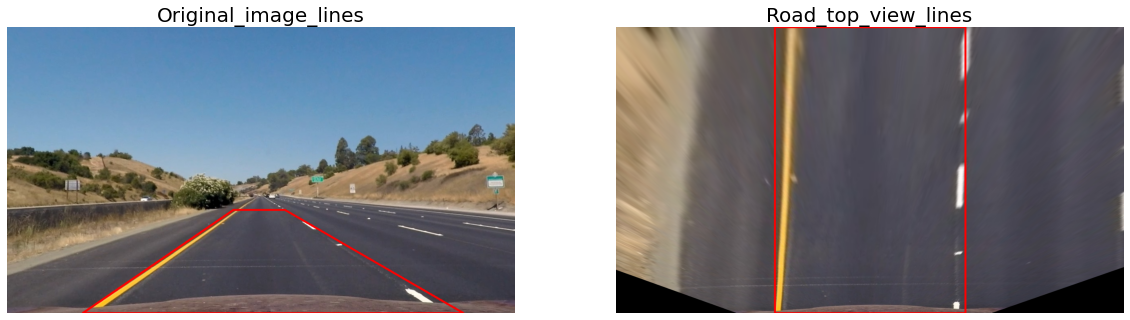

In [24]:
def warp_image(img_path, mtx, dist, visualization = False):
    '''
    helper function to convert the perspective of the image when looked
    form the front of the car or from bird's eye view
    
    '''
    img = cv2.imread(img_path)
    img = undistort(img, mtx, dist)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB )
    xsize = img.shape[1]
    ysize = img.shape[0]
    offset = 400

    src_pts = np.float32([
        (570, 460), # Top-left corner
        (190, 720), # Bottom-left corner
        (1150, 720), # Bottom-right corner
        (700, 460) # Top-right corner
    ])

    dst_pts = np.float32([
        [offset, 0], 
        [offset, ysize],
        [xsize - offset, ysize], 
        [xsize - offset, 0]
    ])
    
    # Get the perspective transformation matrix and its inverse
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    invM = cv2.getPerspectiveTransform(dst_pts, src_pts)
    
    # Warp the image
    warped = cv2.warpPerspective(img, M, (xsize, ysize), flags = cv2.INTER_LINEAR)
    
    if visualization:
        img_cpy = img.copy()
        warped_cpy = warped.copy()
        warped_poly = cv2.polylines(img_cpy, np.int32([src_pts]), True, (255,0,0), 3)
        warped2_poly = cv2.polylines(warped_cpy, np.int32([dst_pts]), True, (255,0,0), 3)
        plot_images([
            (img, 'Original_image'),
            (warped, 'Road_top_view')
        ])
        plot_images([
            (warped_poly, 'Original_image_lines'),
            (warped2_poly, 'Road_top_view_lines')
        ])
test_img_path = './test_images/straight_line_img2.jpg'
test_img = warp_image(test_img_path, mtx, dist, visualization = True)
